In [2]:
from random import random
import warnings
warnings.simplefilter('ignore')

In [3]:
from statsmodels.tsa.arima.model import *
from statsmodels.tsa.ar_model import *
from statsmodels.tsa.statespace.varmax import *
from statsmodels.tsa.holtwinters import *

In [4]:
import matplotlib as mpl
import pandas as pd
import numpy as np
from pandas.plotting import scatter_matrix
from adtk.data import validate_series
from adtk.visualization import plot
from adtk.detector import ThresholdAD
from adtk.detector import OutlierDetector

from sklearn.neighbors import LocalOutlierFactor
from scipy.stats import variation
import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.api import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf,plot_acf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from itertools import compress, product

from pmdarima import auto_arima

import warnings
warnings.filterwarnings("ignore")


In [5]:

def sesonal(data, s):
    plt.figure(figsize=(19,8), dpi= 80)
    for i, y in enumerate(data.index.year.unique()):
        plt.plot(list(range(1,len(data[data.index.year==y])+1)), data[data.index.year==y][data.columns[0]].values, label=y)
    plt.title("Сезонність по періодам")
    plt.legend(loc="best")
    plt.show()
    
def metrics(real, forecast):
    
    if type(real)==pd.core.frame.DataFrame:
        real=real[real.columns[0]].values
    
    print("Тест на стаціонарність:")
    dftest = adfuller(real-forecast, autolag='AIC')
    print("\tT-статистика = {:.3f}".format(dftest[0]))
    print("\tP-значення = {:.3f}".format(dftest[1]))
    print("Критичне значення :")
    for k, v in dftest[4].items():
        print("\t{}: {} - Дані {} стационарні з ймовірністю {}% відсотків".format(k, v, "не" if v<dftest[0] else "", 100-int(k[:-1])))
    
    forecast=np.array(forecast)
    print('MAD:', round(abs(real-forecast).mean(),4))
    print('MSE:', round(((real-forecast)**2).mean(),4))
    print('MAPE:', round((abs(real-forecast)/real).mean(),4))
    print('MPE:', round(((real-forecast)/real).mean(),4))
    print('Стандартна похибка:', round(((real-forecast)**2).mean()**0.5,4)) 

In [108]:
df = pd.read_csv('cardox.csv', parse_dates=['date'], index_col='date')
df.reset_index(inplace=True)

df

,date,value
0,1958-03-01,315.71
1,1958-04-01,317.45
2,1958-05-01,317.50
3,1958-06-01,317.10
4,1958-07-01,315.86
...,...,...
724,2018-07-01,408.71
725,2018-08-01,406.99
726,2018-09-01,405.51
727,2018-10-01,406.00


In [7]:
df.columns = ['Xm', 'Y']

In [8]:
df.index = pd.to_datetime(df['Xm'], format='%Y%m%d')
# month_index = df.index.to_period('M')
del df['Xm']
df

,Y
Xm,
1958-03-01,315.71
1958-04-01,317.45
1958-05-01,317.50
1958-06-01,317.10
1958-07-01,315.86
...,...
2018-07-01,408.71
2018-08-01,406.99
2018-09-01,405.51


[<Axes: >]

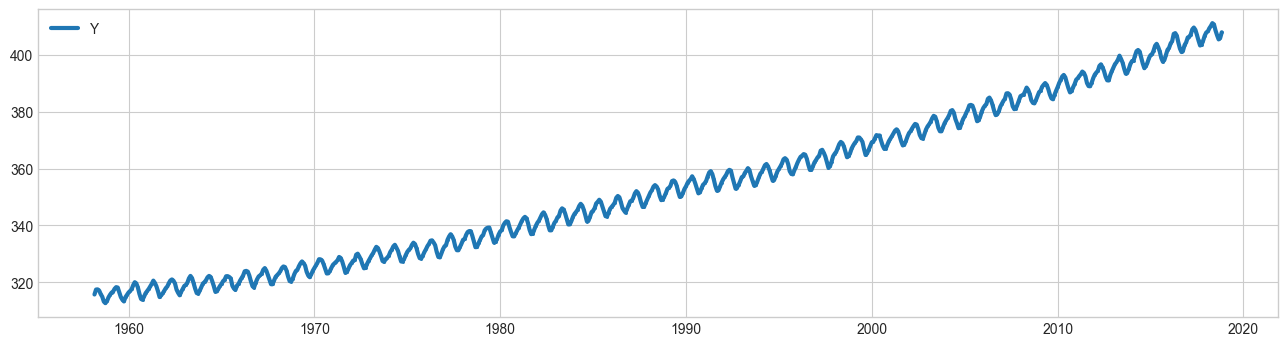

In [9]:
plot(df,ts_linewidth=3)

In [10]:
df.describe()

,Y
count,729.000000
mean,353.787229
std,27.547500
min,312.660000
25%,328.570000
50%,351.410000
75%,375.990000
max,411.240000


[<Axes: >]

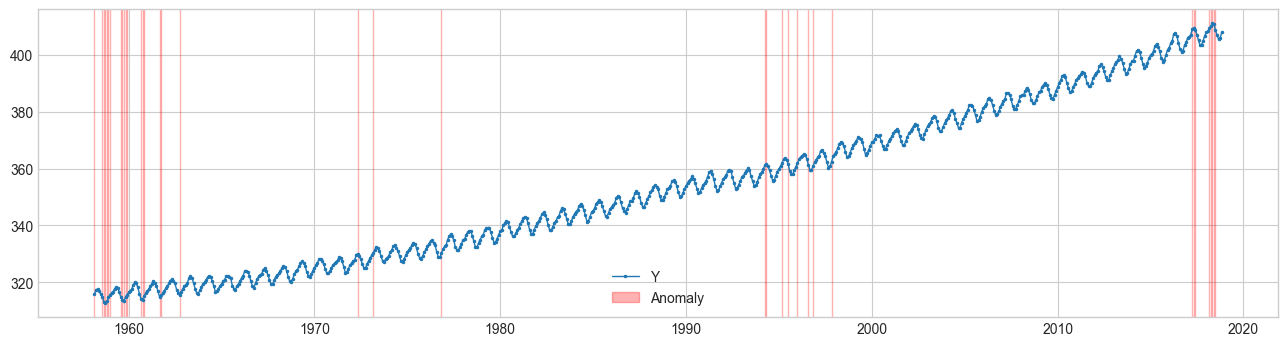

In [11]:
out_detector = OutlierDetector(LocalOutlierFactor(contamination=0.05))
anomalies = out_detector.fit_detect(df)
plot(df,anomaly=anomalies, ts_linewidth=1, ts_markersize=3, anomaly_color='red', anomaly_alpha=0.3, curve_group='all')

In [12]:
anomalies[anomalies]

Xm
1958-03-01    True
1958-08-01    True
1958-09-01    True
1958-10-01    True
1958-11-01    True
1958-12-01    True
1959-01-01    True
1959-08-01    True
1959-09-01    True
1959-10-01    True
1959-11-01    True
1959-12-01    True
1960-09-01    True
1960-10-01    True
1960-11-01    True
1961-09-01    True
1961-10-01    True
1962-10-01    True
1972-05-01    True
1973-03-01    True
1976-11-01    True
1994-04-01    True
1994-05-01    True
1995-03-01    True
1995-07-01    True
1996-01-01    True
1996-08-01    True
1996-11-01    True
1997-11-01    True
2017-04-01    True
2017-05-01    True
2017-06-01    True
2018-03-01    True
2018-04-01    True
2018-05-01    True
2018-06-01    True
2018-07-01    True
dtype: bool

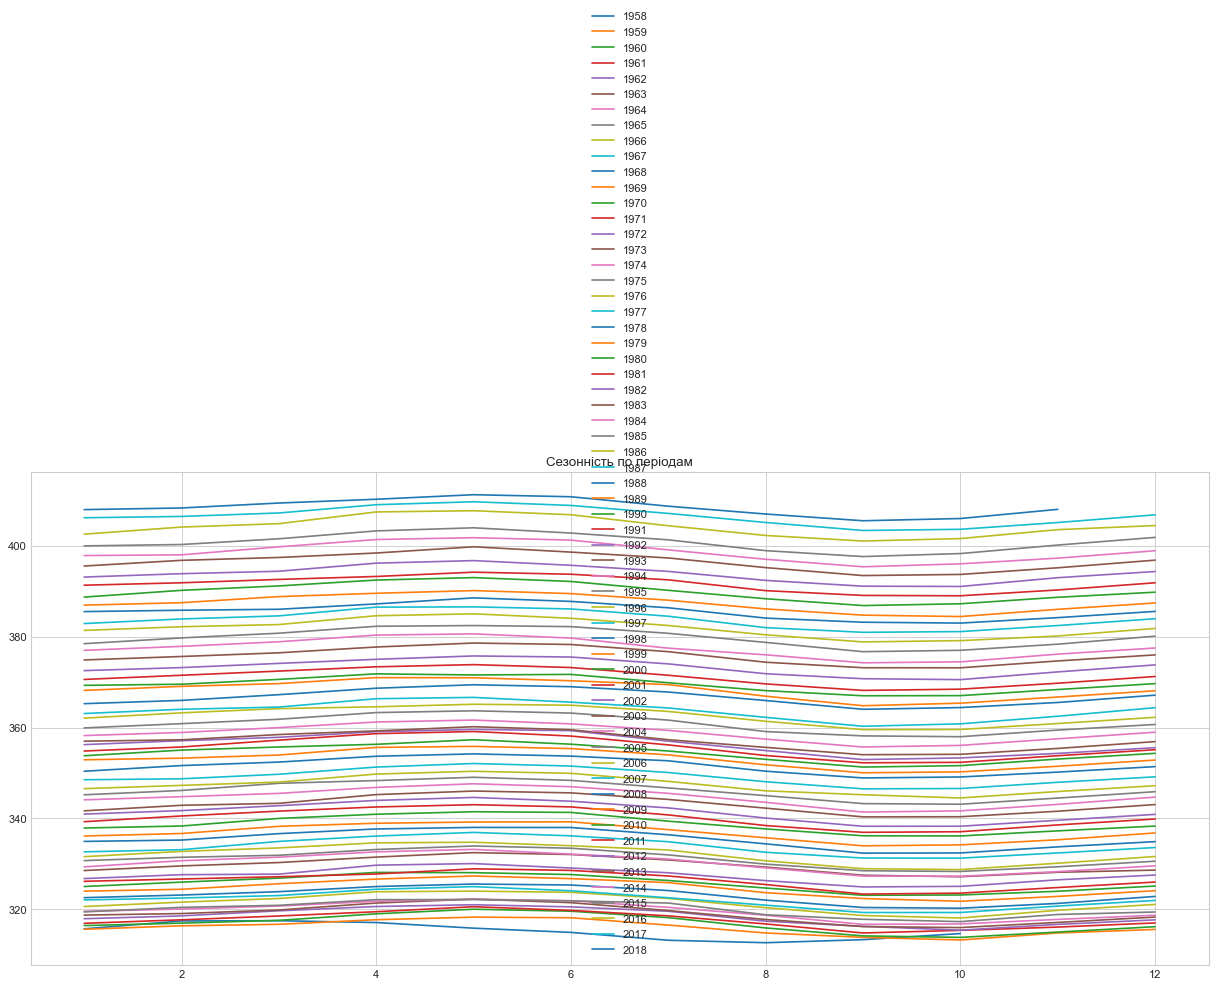

In [13]:
sesonal(df,12)

Text(0.5, 0.98, 'Мультиплікатива модель')

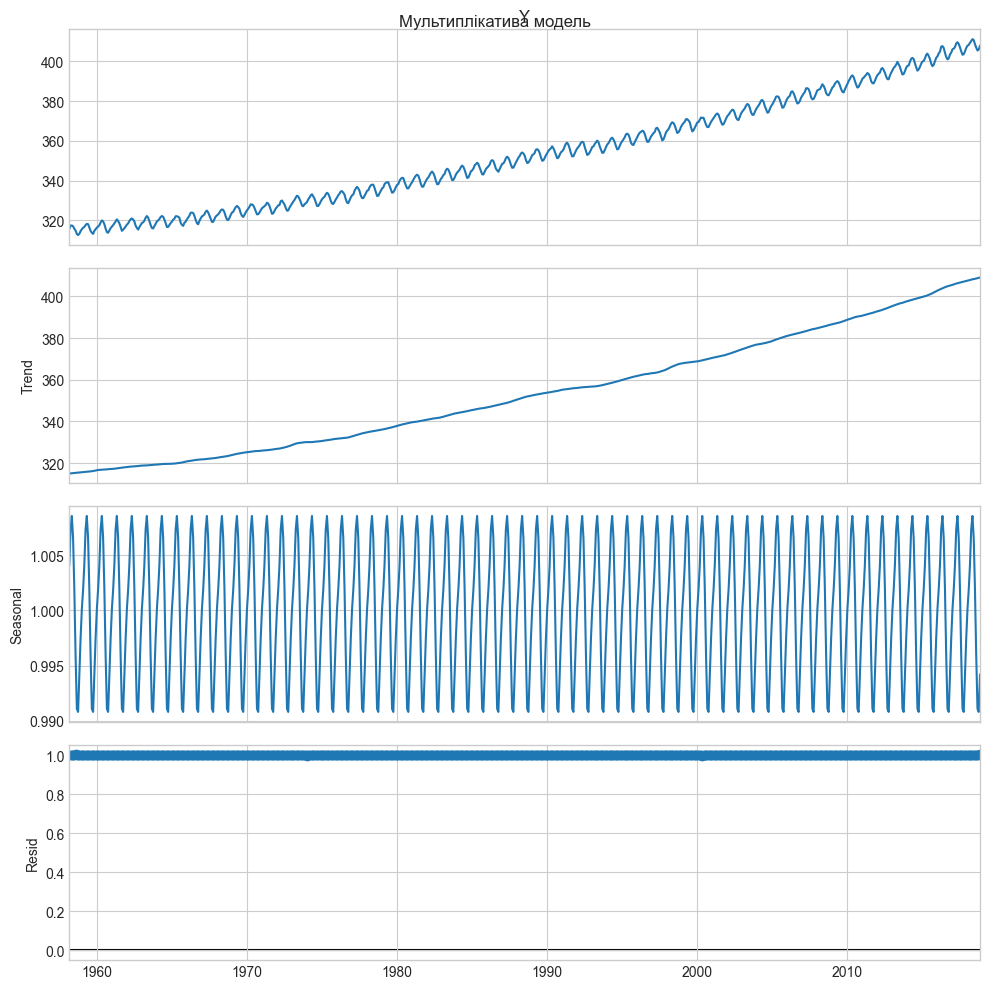

In [14]:
# декомпозиция 
result_M = seasonal_decompose(df.Y, model='multiplicative', extrapolate_trend=12)

# Построение графика
plt.rcParams.update({'figure.figsize': (10,10)})
result_M.plot().suptitle('Мультиплікатива модель')

In [142]:
# df.loc['2018-01-01']=df.loc['2017-01-01']
# df.loc['2018-02-01']=df.loc['2017-02-01']
# df.loc['2018-03-01']=df.loc['2017-03-01']
# df.loc['2018-04-01']=df.loc['2017-04-01']
# df.loc['2018-05-01']=df.loc['2017-05-01']
# df.loc['2018-06-01']=df.loc['2017-06-01']

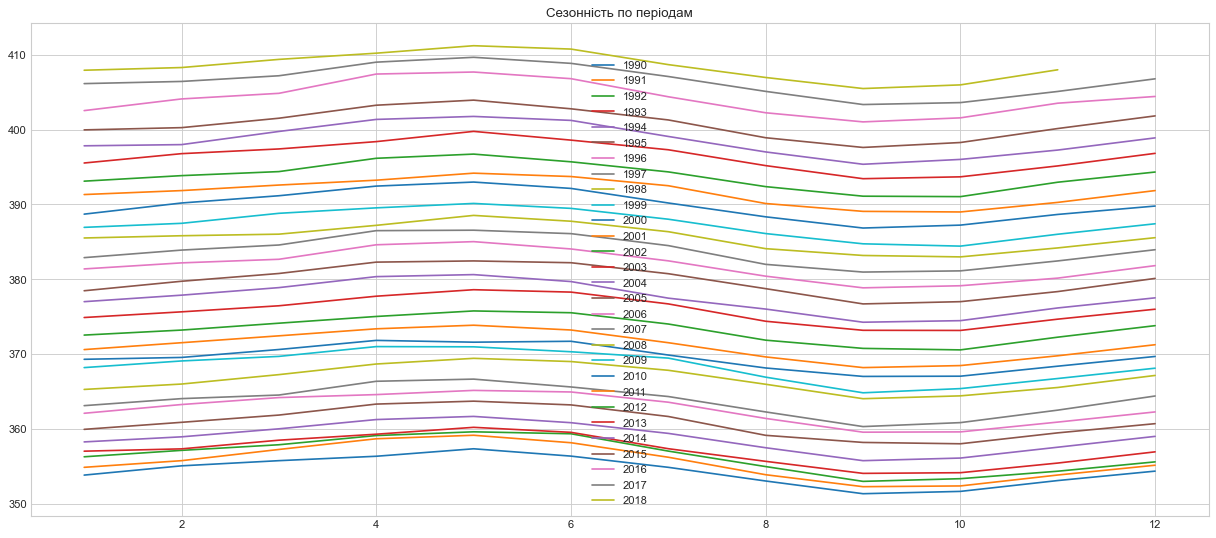

In [15]:
sesonal(df['1990':],12)

In [18]:
train = df['1990':'2012']
test = df['2013':'2018']


# HWES (Хольта вінтерса)

In [19]:
fit1 = ExponentialSmoothing(train, seasonal_periods=12, trend='add', seasonal='mul').fit()


In [20]:
fit1.params

{'smoothing_level': 0.6709770836716271,
 'smoothing_trend': 1.6761155549504893e-13,
 'smoothing_seasonal': 2.46676383152419e-14,
 'damping_trend': nan,
 'initial_level': 354.3264930185392,
 'initial_trend': 0.15109403628620133,
 'initial_seasons': array([0.99841263, 1.00019633, 1.00212762, 1.00505301, 1.00604351,
        1.00399616, 0.99934866, 0.99341218, 0.98898209, 0.98895938,
        0.99230804, 0.99573895]),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [24]:
fit1.forecast(12*36)

2013-01-01    395.551529
2013-02-01    396.409317
2013-03-01    397.326166
2013-04-01    398.637891
2013-05-01    399.182764
                 ...    
2048-08-01    457.662576
2048-09-01    455.771072
2048-10-01    455.910031
2048-11-01    457.603696
2048-12-01    459.336314
Freq: MS, Length: 432, dtype: float64

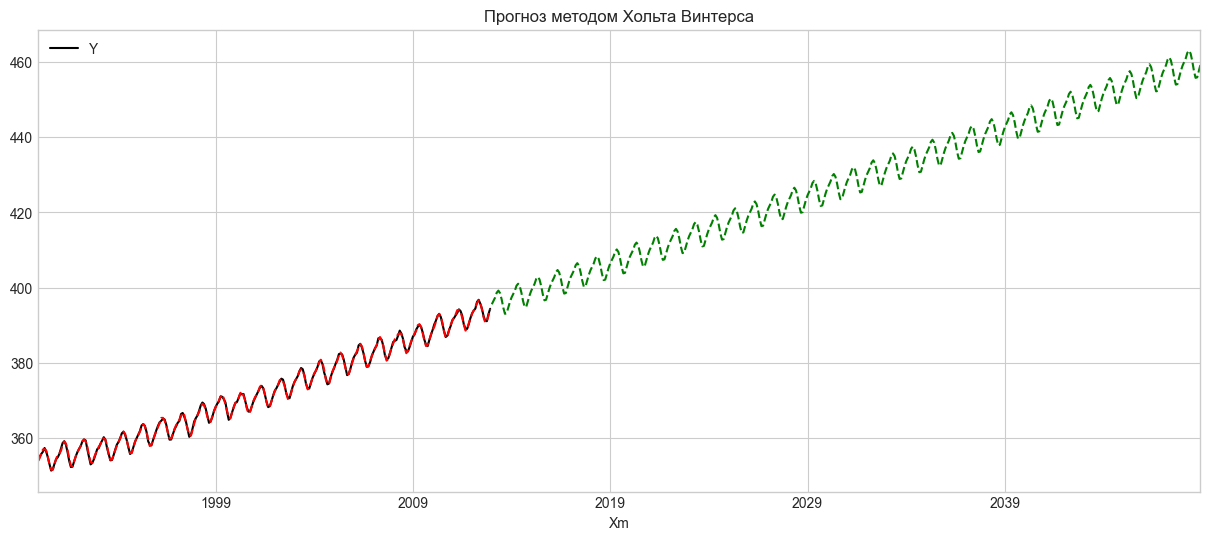

In [27]:
ax = train.plot(figsize=(15,6), color='black', title="Прогноз методом Хольта Винтерса" )
fit1.fittedvalues.plot(ax=ax, style='--', color='red')
fit1.forecast(12*36).plot(ax=ax, style='--', color='green')
plt.show()

In [28]:
metrics(test, fit1.forecast(len(test)))

Тест на стаціонарність:
	T-статистика = -0.047
	P-значення = 0.954
Критичне значення :
	1%: -3.5335601309235605 - Дані не стационарні з ймовірністю 99% відсотків
	5%: -2.9064436883991434 - Дані не стационарні з ймовірністю 95% відсотків
	10%: -2.590723948576676 - Дані не стационарні з ймовірністю 90% відсотків
MAD: 1.845
MSE: 4.9576
MAPE: 0.0046
MPE: 0.0045
Стандартна похибка: 2.2266


# SARIMAX

In [29]:
model = auto_arima(train, seasonal=True, m=12, trace=True, suppress_warnings=True, error_action='ignore', stepwise=True)
model


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=234.402, Time=2.25 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=909.671, Time=0.04 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=inf, Time=0.69 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=612.701, Time=0.49 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=911.435, Time=0.05 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=432.362, Time=2.37 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=319.862, Time=2.56 sec
 ARIMA(2,1,2)(2,0,1)[12] intercept   : AIC=244.905, Time=5.19 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=244.746, Time=5.20 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=538.256, Time=0.85 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=384.236, Time=5.14 sec
 ARIMA(2,1,2)(2,0,0)[12] intercept   : AIC=265.493, Time=5.08 sec
 ARIMA(2,1,2)(2,0,2)[12] intercept   : AIC=227.579, Time=6.18 sec
 ARIMA(1,1,2)(2,0,2)[12] intercept   : AIC=inf, Time=6.11 sec
 ARIMA(2,1,1)(2,0,2)[12] intercept   : AI

ARIMA(order=(2, 1, 2), scoring_args={}, seasonal_order=(2, 0, 2, 12),
      suppress_warnings=True)

In [30]:
mod = sm.tsa.statespace.SARIMAX(train,
                                order=(2, 1, 2),
                                seasonal_order=(2, 0, 2, 12))

results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8705      0.033     26.423      0.000       0.806       0.935
ar.L2         -0.1768      0.002    -76.166      0.000      -0.181      -0.172
ma.L1         -1.1719      0.017    -70.750      0.000      -1.204      -1.139
ma.L2          0.3628      0.020     18.187      0.000       0.324       0.402
ar.S.L12       0.0381      0.004      8.867      0.000       0.030       0.047
ar.S.L24       0.9615      0.004    227.104      0.000       0.953       0.970
ma.S.L12       0.0789      0.010      8.272      0.000       0.060       0.098
ma.S.L24      -0.8740      0.058    -15.072      0.000      -0.988      -0.760
sigma2         0.0921      0.009     10.449      0.000       0.075       0.109


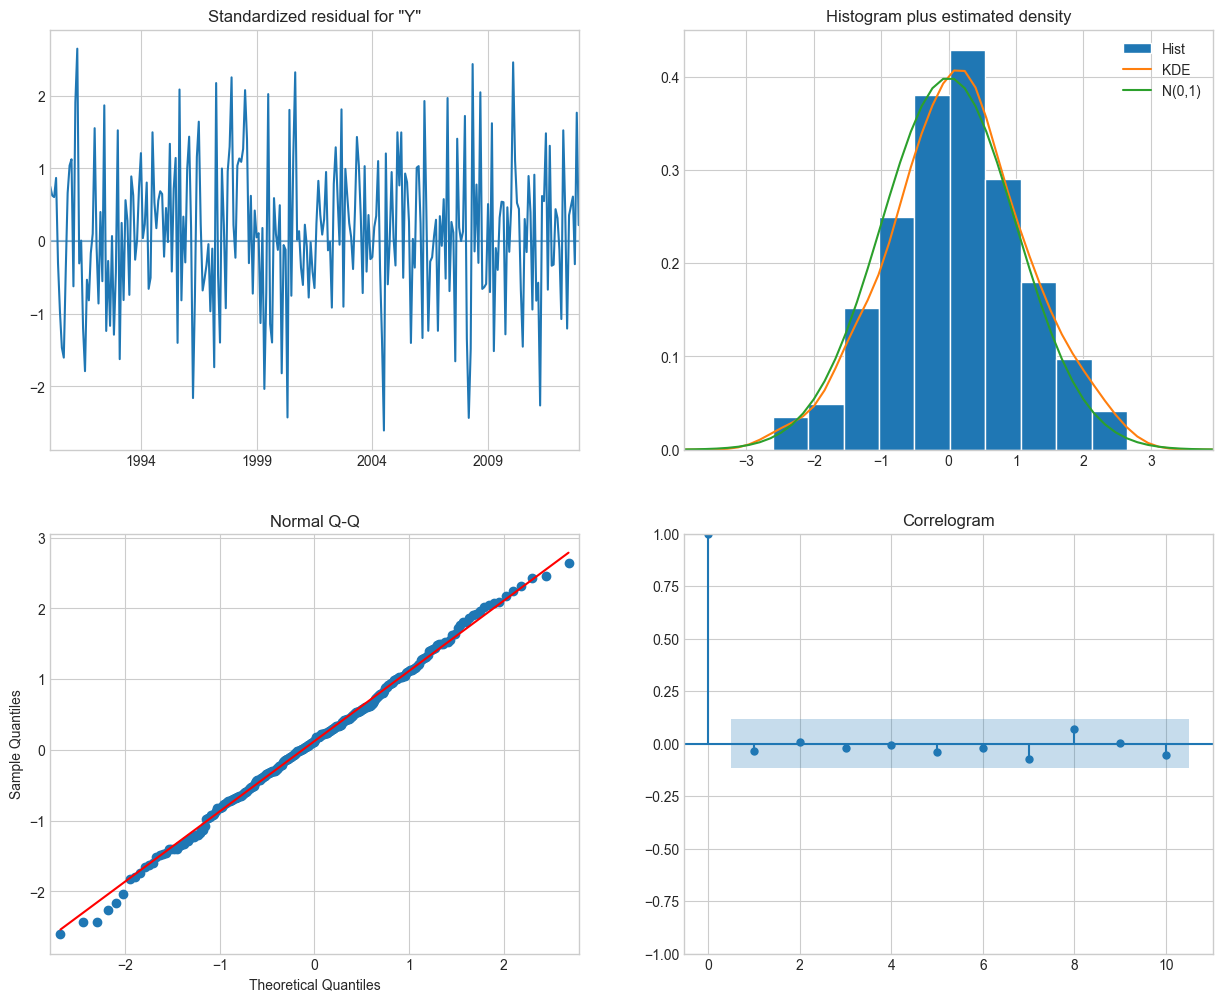

In [31]:
results.plot_diagnostics(figsize = (15,12))
plt.show()

In [55]:
predict=results.get_prediction()
predict.predicted_mean[:10]

1990-01-01      0.000000
1990-02-01    353.799754
1990-03-01    354.726662
1990-04-01    355.359829
1990-05-01    355.945069
1990-06-01    356.823956
1990-07-01    356.377341
1990-08-01    355.336322
1990-09-01    353.853111
1990-10-01    352.287414
Freq: MS, Name: predicted_mean, dtype: float64

In [56]:
predict=results.get_prediction(start='1990-02-01')
metrics(train['1990-02-01':], predict.predicted_mean)

Тест на стаціонарність:
	T-статистика = -12.050
	P-значення = 0.000
Критичне значення :
	1%: -3.4544435065994437 - Дані  стационарні з ймовірністю 99% відсотків
	5%: -2.8721468827772774 - Дані  стационарні з ймовірністю 95% відсотків
	10%: -2.572422013959188 - Дані  стационарні з ймовірністю 90% відсотків
MAD: 0.2975
MSE: 0.1951
MAPE: 0.0008
MPE: 0.0001
Стандартна похибка: 0.4417


In [73]:
predict=results.get_prediction(start='2013', end='2048')
predict.predicted_mean['2019':]

2019-01-01    407.195710
2019-02-01    407.998569
2019-03-01    408.807707
2019-04-01    410.082996
2019-05-01    410.647336
                 ...    
2047-09-01    459.353414
2047-10-01    459.446107
2047-11-01    460.867114
2047-12-01    462.283939
2048-01-01    463.479976
Freq: MS, Name: predicted_mean, Length: 349, dtype: float64

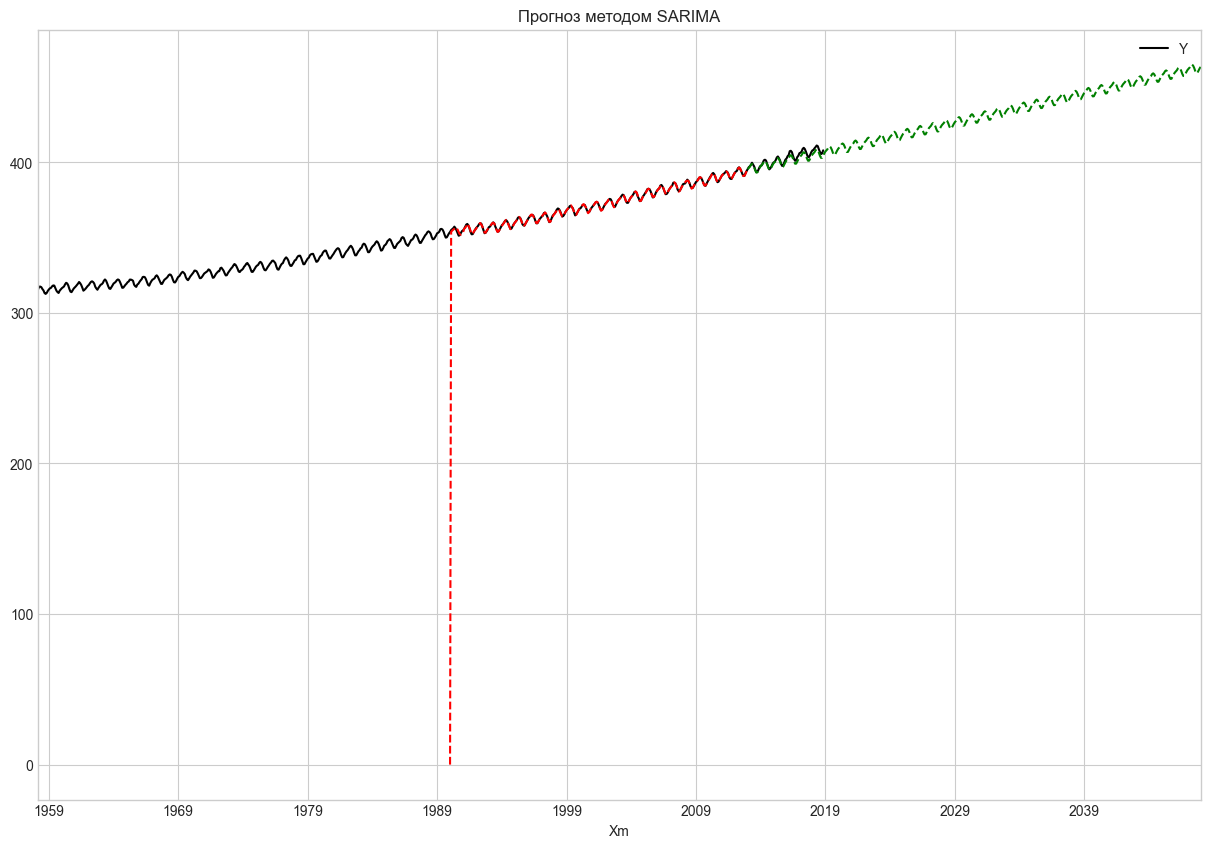

In [70]:
ax = df.plot(figsize=(15,10), color='black', title="Прогноз методом SARIMA" )
results.fittedvalues.plot(ax=ax, style='--', color='red')
predict.predicted_mean.plot(ax=ax, style='--', color='green')
plt.show()

In [91]:
values = list(predict.predicted_mean['2019':])
# print(values)
idx=list(predict.predicted_mean['2019':].index)
predictions = pd.Series(values, index=idx)

In [93]:
dataframe= pd.DataFrame(data=predictions, columns=['Y'])
dataframe

,Y
2019-01-01,407.195710
2019-02-01,407.998569
2019-03-01,408.807707
2019-04-01,410.082996
2019-05-01,410.647336
...,...
2047-09-01,459.353414
2047-10-01,459.446107
2047-11-01,460.867114
2047-12-01,462.283939


In [100]:
dataframe.to_csv('F:/data_science_course/git/Lesson_46/cardox_new.csv', index_label='Xm')

In [104]:
df=pd.read_csv('F:/data_science_course/git/Lesson_46/cardox_new.csv', index_col=0)
df

,Y
Xm,
2019-01-01,407.195710
2019-02-01,407.998569
2019-03-01,408.807707
2019-04-01,410.082996
2019-05-01,410.647336
...,...
2047-09-01,459.353414
2047-10-01,459.446107
2047-11-01,460.867114
